## Simplified graph with energy consumption, fuel use and emissions
In this notebook, we set up a basic simulation where a vessel moves over a 1D netork path. We add some properties to the graph (depth, width) and the vessel (VesselProperties, ConsumesEnergy) in order to calculate resistance, required power, and emissions.
OpenTNSim model run. 

We take the following steps:

1. [Imports](#1.-Imports)
2. [Create vessel](#2.-Create-vessel)
3. [Create graph](#3.-Create-graph)
4. [Run simulation](#4.-Run-simulation)
5. [Inspect output](#5.-Inspect-output)

### 1. Imports
We start with importing required libraries

In [1]:
# package(s) used for creating and geo-locating the graph
import networkx as nx  
from shapely.geometry import Point, LineString

# package(s) related to the simulation (creating the vessel, running the simulation)
import datetime, time
import simpy
import opentnsim
from opentnsim import core as core_module
from opentnsim import energy as energy_module
from opentnsim import graph as graph_module
from opentnsim import output as output_module
from opentnsim import vessel as vessel_module
from opentnsim import vessel_traffic_service as vessel_traffic_service_module

import pandas as pd

# package(s) needed for plotting
import matplotlib.pyplot as plt

### 2. Create vessel
We start with creating a vessel class. We call this class a *Vessel*, and add a number of OpenTNSim mix-ins to this class. Each mix-in requires certain input parameters. 

The following mix-ins are sufficient to create a vessel for our problem: 
* _Identifiable_ - allows to give the vessel a name and a random ID, 
* _Movable_ - allows the vessel to move, with a fixed speed, while logging this activity,
   * Movable in turn relies on the mix-ins: _Locatable_, _Routeable_, and _Log_
* _VesselProperties_ - allows to give the vessel specific properties, 
* _ConsumesEnergy_ - enables calculation of resistance, required power and emissions

In [2]:
#We create a type element that schematisizes a vessel
def create_vessel(env,
                  name,
                  origin, 
                  destination, 
                  vessel_type, 
                  L, 
                  B, 
                  T,
                  P_tot_given, 
                  arrival_time):
    
    Vessel = type('Vessel',(energy_module.ConsumesEnergy,   # The vessel consumes energy
                            vessel_module.IsVessel,         # Basic information of the vessel
                           ),{})  
    
    vessel = Vessel(**{ "env": env,
                        "name": name,
                        "origin": origin,
                        "destination": destination,
                        "type": vessel_type,
                        "L": L,
                        "B": B,
                        "T": T,
                        "safety_margin": 0.2, # for tanker vessel with sandy bed the safety margin is recommended as 0.2 m
                        "h_squat": True, # if consider the ship squatting while moving, set to True, otherwise set to False
                        "P_installed": 1750.0,
                        "P_tot_given": P_tot_given, # kW
                        "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
                        "P_hotel_perc": 0.05,
                        "P_hotel": None, # None: calculate P_hotel from percentage
                        "x": 2,# number of propellers
                        "L_w": 3.0 ,
                        "C_B": 0.85, 
                        "C_year": 1990,
                        "arrival_time": arrival_time,
                      }
                   )

    env.process(vessel.move())
    
    return vessel

### 2. Create graph
Next we create a 1D network (a graph) along which the vessel can move. A graph is made of nodes (blue dots in the plot below) and edges (red arrows between the nodes in the plot below). We use the python package networkx to do this. 

For this example, we construct a network of 4 nodes linked by 3 edges. The edges are made bi-directional to allow for two-way traffic, which means that the graph in the end contains 6 edges.

In [3]:
FG = nx.DiGraph()
node_A = graph_module.Node(name='0',geometry=Point(0,0))
node_B = graph_module.Node(name='1',geometry=Point(0.8983,0))
node_C = graph_module.Node(name='2',geometry=Point(1.7966,0))
node_D = graph_module.Node(name='3',geometry=Point(2.6949,0))
edges = [(node_A,node_B),(node_B,node_C),(node_C,node_D)]
depths = {"GeneralDepth": [6.0,6.0,4.5]}
FG = graph_module.DiGraph(edges=edges,edges_info=depths).graph

In [4]:
FG.edges['2','3']

{'weight': 1,
 'geometry': <LINESTRING (1.797 0, 2.695 0)>,
 'length': 99998.29857959767,
 'Info': {'GeneralDepth': 4.5}}

In [5]:
# collect node positions and labels
nodes = []
coordinates = []
labels = {}

for node in FG.nodes:
    nodes.append(node)
    coordinates.append([nx.get_node_attributes(FG, 'geometry')[node].x, nx.get_node_attributes(FG, 'geometry')[node].y])
    labels[node] = node
    
positions = dict(zip(nodes, coordinates))

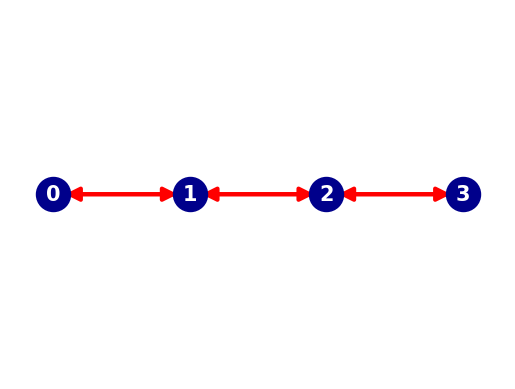

In [6]:
# draw edges, nodes and labels
nx.draw_networkx_edges(FG, pos=positions, width=3, edge_color="red", alpha=1, arrowsize=20)
nx.draw_networkx_nodes(FG, pos=positions, node_color="darkblue", node_size=600)
nx.draw_networkx_labels(FG, pos=positions, labels=labels, font_size=15, font_weight="bold", font_color="white")

plt.axis("off")
plt.show()

In [7]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))

General depth for edge ('0', '1') is 6.0
General depth for edge ('1', '0') is 6.0
General depth for edge ('1', '2') is 6.0
General depth for edge ('2', '1') is 6.0
General depth for edge ('2', '3') is 4.5
General depth for edge ('3', '2') is 4.5


### 4. Run simulation
Now we can define the run. After we define the path that the vessel will sail, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

In [8]:
# Start simpy environment
t_start = datetime.datetime(2024, 1, 1, 0, 0, 0)

env = simpy.Environment(initial_time=t_start.timestamp())

env.epoch = t_start
env.simulation_start = t_start

# Add graph to environment
env.FG = FG

#In order from ships to know where they are going we need to add an VTS to the environment
env.vessel_traffic_service = vessel_traffic_service_module.VesselTrafficService(env=env)

vessel_I = create_vessel(env=env,
                         name='Vessel_I',
                         origin='0', 
                         destination='3', 
                         vessel_type='inland vessel', 
                         L=100, 
                         B=15, 
                         T=4,
                         P_tot_given=3, 
                         arrival_time=datetime.datetime(2024, 1, 1, 0, 0, 0))

In [9]:
env.run()

c:\users\floorbakker\opentnsim\opentnsim\energy.py:383: RuntimeWarning:

invalid value encountered in scalar power



The energy calculation is performed as a postprocessing step. It requires is input the graph (to acquire information on the water depth) and the vessel log data that was generated during the move activity. The energy use is stored as a dict under _energy_use_ in the energycalculation object.

In [10]:
energycalculation = opentnsim.energy.EnergyCalculation(env.FG, vessel_I)
energycalculation.calculate_energy_consumption()

5.999999999454232
5.999999999454222
4.499999998537927


### 5. Inspect output
We can now analyse the simulation output by inspecting the data in _energy_use_ in the energycalculation object. For convenient inspection it can be loaded into a Pandas dataframe. 

In [11]:
# create dataframe from energy calculation computation
df = pd.DataFrame.from_dict(energycalculation.energy_use)
df

,time_start,time_stop,edge_start,edge_stop,P_tot,P_given,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_mass,...,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t
0,2024-01-01 00:00:00.000000,2037-04-28 11:57:06.646371,POINT (0 0),POINT (0.8983 0),87.499999,87.499999,1750.0,1.021965e+07,2.810403e+09,2.880656e+09,...,1.161323e+11,91903.288859,6387.278576,8.916641e+09,9.974374e+06,1.888897e+08,1.021965e+07,6.0,99998.29858,4.204654e+08
1,2037-04-28 11:57:06.646371,2050-08-24 22:54:13.292743,POINT (0.8983 0),POINT (1.7966 0),87.499999,87.499999,1750.0,1.021956e+07,2.810379e+09,2.880631e+09,...,1.161313e+11,91902.502013,6387.223890,8.916565e+09,9.974289e+06,1.888881e+08,1.021956e+07,6.0,99998.29858,4.204618e+08
2,2050-08-24 22:54:13.292743,2059-12-05 08:00:11.183796,POINT (1.7966 0),POINT (2.6949 0),87.500000,87.500000,1750.0,7.117696e+06,1.957366e+09,2.006296e+09,...,8.088291e+10,64008.059356,4448.560125,6.210190e+09,6.946871e+06,1.315564e+08,7.117696e+06,4.5,99998.29858,2.928424e+08


In [12]:
df['fuel_kg_per_km'] = (df['total_diesel_consumption_ICE_mass'] / 1000) / (df['distance']/1000)
df['CO2_g_per_km']   = (df['total_emission_CO2']) / (df['distance']/1000)
df['PM10_g_per_km']  = (df['total_emission_PM10']) / (df['distance']/1000)
df['NOx_g_per_km']   = (df['total_emission_NOX']) / (df['distance']/1000)
df

,time_start,time_stop,edge_start,edge_stop,P_tot,P_given,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_mass,...,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t,fuel_kg_per_km,CO2_g_per_km,PM10_g_per_km,NOx_g_per_km
0,2024-01-01 00:00:00.000000,2037-04-28 11:57:06.646371,POINT (0 0),POINT (0.8983 0),87.499999,87.499999,1750.0,1.021965e+07,2.810403e+09,2.880656e+09,...,9.974374e+06,1.888897e+08,1.021965e+07,6.0,99998.29858,4.204654e+08,28807.050250,8.916793e+07,99745.439327,1.888929e+06
1,2037-04-28 11:57:06.646371,2050-08-24 22:54:13.292743,POINT (0.8983 0),POINT (1.7966 0),87.499999,87.499999,1750.0,1.021956e+07,2.810379e+09,2.880631e+09,...,9.974289e+06,1.888881e+08,1.021956e+07,6.0,99998.29858,4.204618e+08,28806.803614,8.916716e+07,99744.585339,1.888913e+06
2,2050-08-24 22:54:13.292743,2059-12-05 08:00:11.183796,POINT (1.7966 0),POINT (2.6949 0),87.500000,87.500000,1750.0,7.117696e+06,1.957366e+09,2.006296e+09,...,6.946871e+06,1.315564e+08,7.117696e+06,4.5,99998.29858,2.928424e+08,20063.301381,6.210296e+07,69469.896885,1.315586e+06


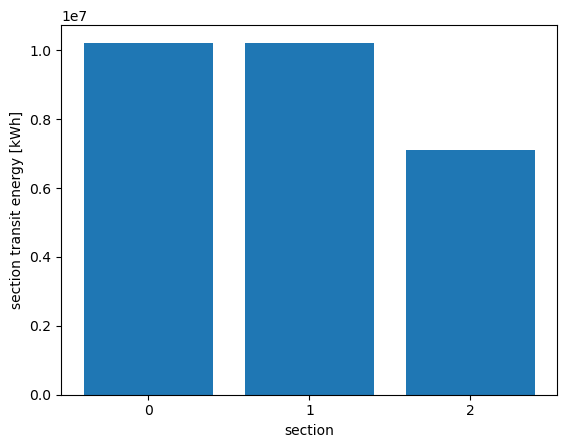

In [13]:
plt.bar(df.index,df.total_energy)
plt.ylabel('section transit energy [kWh]')
plt.xlabel('section')
plt.xticks([0,1,2]);

In [14]:
durations=[]
for index, row in df.iterrows():
    durations.append((df.time_stop[index]-df.time_start)[index].total_seconds()/60)
durations

[7007757.11077285, 7007697.110772867, 4880705.964850884]

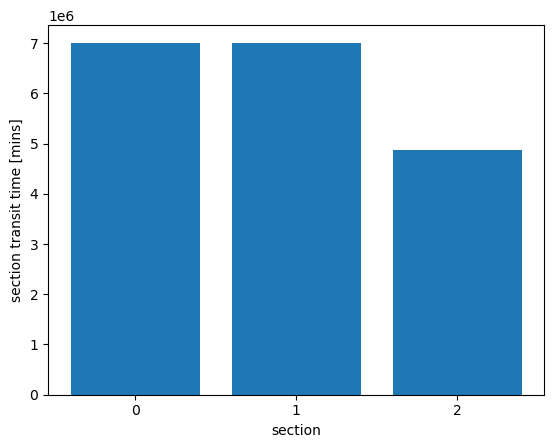

In [15]:
plt.bar(df.index,durations)
plt.ylabel('section transit time [mins]')
plt.xlabel('section')
plt.xticks([0,1,2]);